In [1]:
# Read the dataset
import scipy.io as spio
import numpy as np

BahramFace = spio.loadmat(file_name='/home/arasdar/datasets/bci-project-data-RAW/BahramFace.mat')
DJFace = spio.loadmat(file_name='/home/arasdar/datasets/bci-project-data-RAW/DJFace.mat')
NickFace = spio.loadmat(file_name='/home/arasdar/datasets/bci-project-data-RAW/NickFace.mat')
RoohiFace = spio.loadmat(file_name='/home/arasdar/datasets/bci-project-data-RAW/RoohiFace.mat')
SarahFace = spio.loadmat(file_name='/home/arasdar/datasets/bci-project-data-RAW/SarahFace.mat')

AllData = np.concatenate((BahramFace['Intensification_Data'],
                            DJFace['Intensification_Data'],
                            NickFace['Intensification_Data'],
                            RoohiFace['Intensification_Data'],
                            SarahFace['Intensification_Data']), axis=0)

AllLabels = np.concatenate((BahramFace['Intensification_Label'],
                            DJFace['Intensification_Label'],
                            NickFace['Intensification_Label'],
                            RoohiFace['Intensification_Label'],
                            SarahFace['Intensification_Label']), axis=0)

print(AllData.shape, AllData.dtype, AllLabels.shape, AllLabels.dtype)
print(np.mean(AllLabels==0), np.mean(AllLabels==1), np.mean(AllLabels==2), np.mean(AllLabels==3))
print((AllLabels +  1).max(axis=0))

(18720, 205, 16) float64 (18720, 1) uint8
0.833333333333 0.166666666667 0.0 0.0
[2]


In [2]:
# Train and test split
from sklearn.model_selection import train_test_split

X_train_valid, X_test, Y_train_valid, Y_test = train_test_split(AllData, AllLabels, test_size=0.30)

print(X_train_valid.shape, X_test.shape, Y_train_valid.shape, Y_test.shape)

(13104, 205, 16) (5616, 205, 16) (13104, 1) (5616, 1)


In [3]:
from utilities import *

# Normalizing/standardizing the input data features
X_train_valid_norm, X_test_norm = standardize(test=X_test, train=X_train_valid)

# Onehot encoding/vectorizing the output data labels
print(np.mean((Y_train_valid+1).reshape(-1)==0), np.mean((Y_train_valid+1).reshape(-1)==1),
     np.mean((Y_train_valid+1).reshape(-1)==2), np.mean((Y_train_valid+1).reshape(-1)==3))

print(np.mean((Y_test+1).reshape(-1)==0), np.mean((Y_test+1).reshape(-1)==1),
     np.mean((Y_test+1).reshape(-1)==2), np.mean((Y_test+1).reshape(-1)==3))

# Y_train_valid_onehot = one_hot(labels=(Y_train_valid+1).reshape(-1), n_class=2) 
# print(Y_train_valid_onehot.shape, Y_train_valid_onehot.dtype, 
Y_test_onehot = one_hot(labels=(Y_test+1).reshape(-1), n_class=2) 
print(Y_test_onehot.shape, Y_test_onehot.dtype)

0.0 0.833638583639 0.166361416361 0.0
0.0 0.832621082621 0.167378917379 0.0
(5616, 2) float64


In [4]:
# X_train_valid, X_test, Y_train_valid, Y_test = train_test_split(AllData, AllLabels, test_size=0.30)
X_train_norm, X_valid_norm, Y_train, Y_valid = train_test_split(X_train_valid_norm, Y_train_valid, 
                                                                              test_size=0.30)

In [5]:
def get_batches2(X_norm, Y_labels, kernel_size_ratio=1, strides_ratio=1):
    # X normalized and Y NOT onehot encoded/vectorized
    X, Y = X_norm, Y_labels
    AllLabels = Y_labels # 100%

    # non = 0 is 87%  AllLabelZero
    # tgt = 1 is 13%  AllLabelOne
    AllLabelZero = (AllLabels==0).reshape(-1) # 87%
    AllLabelOne = (AllLabels==1).reshape(-1) # 13%

    X_non, Y_non = X[AllLabelZero], Y[AllLabelZero] # 87%
    X_tgt, Y_tgt = X[AllLabelOne], Y[AllLabelOne] # 13%
#     print('X_non.shape, Y_non.shape', X_non.shape, Y_non.shape)
#     print('X_tgt.shape, Y_tgt.shape', X_tgt.shape, Y_tgt.shape)

    # Non-target batch size for get_batches from non-target data
    batch_size = X_tgt.shape[0] # 13% -> tgt = 1 is 13%  AllLabelOne
    assert X_tgt.shape[0] == Y_tgt.shape[0]
#     print('batch_size', batch_size)
    
    # Convolvolutional minibatching technique
    (inputs, filters, kernel_size, strides, padding) = (X_non, 1, 
                                                        int(batch_size//kernel_size_ratio), 
                                                        int(batch_size//strides_ratio), 
                                                        0)
#     print('inputs.shape, filters, kernel_size, strides, padding', inputs.shape, filters, 
#           kernel_size, strides, padding)
    n_batches = int((inputs.shape[0] - kernel_size + (2*padding))//strides  + 1) 
#     print('n_batches', n_batches)
    
    # Loop over target batches: start, stop, step
    for i in range(0, n_batches, 1):
        each_X_norm = np.concatenate((X_non[(i*strides):((i*strides)+kernel_size)], X_tgt), axis=0)
        each_Y = np.concatenate((Y_non[(i*strides):((i*strides)+kernel_size)], Y_tgt), axis=0)
        each_Y_onehot = one_hot(labels=(each_Y+1).reshape(-1), n_class=2)
#         print('each_X_norm.shape, each_Y_onehot.shape', each_X_norm.shape, each_Y_onehot.shape)
#         print('np.mean(each_Y==0), np.mean(each_Y==1)', np.mean(each_Y==0), np.mean(each_Y==1))
        yield each_X_norm, each_Y_onehot

In [6]:
get_batches2(X_norm=X_valid_norm, Y_labels=Y_valid, kernel_size_ratio=1, strides_ratio=2)

<generator object get_batches2 at 0x7f2324ff5e60>

In [7]:
get_batches2(X_norm=X_train_norm, Y_labels=Y_train, kernel_size_ratio=1, strides_ratio=2)

<generator object get_batches2 at 0x7f2320db7d00>

In [8]:
## Hyperparameters
# Input data
# batch_size = X_train_norm.shape[0]// 100 # minibatch size & number of minibatches
seq_len = X_train_norm.shape[1] # Number of steps: each trial length
n_channels = X_train_norm.shape[2] # number of channels in each trial
# print('batch_size, seq_len, n_channels', batch_size, seq_len, n_channels)
print('seq_len, n_channels', seq_len, n_channels)

# Output labels
n_classes = Y_train_valid.max(axis=0)+1
assert Y_train_valid.max(axis=0) == Y_test.max(axis=0)
print('n_classes', n_classes)

# learning parameters
learning_rate = 0.0001 #1e-4
keep_prob = 0.50 # 90% neurons are kept and 10% are dropped out

seq_len, n_channels 205 16
n_classes [2]


In [9]:
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


In [10]:
# Feed the data from python/numpy to tensorflow framework
inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs_')
labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels_')
keep_prob_ = tf.placeholder(tf.float32, name = 'keep_prob_')
learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate_')
print('inputs_.shape, labels_.shape', inputs_.shape, labels_.shape)

inputs_.shape, labels_.shape (?, 205, 16) (?, 2)


In [11]:
# inputs_.shape, labels_.shape (?, 205, 16) (?, 2)
# (batch, 205, 16) --> (batch, 102, 32)
# conv valid: (205-2+0)/1 + 1 = (203/1)+1 = 203 + 1=204
# pool same: (204-2+0)/2 + 1 = (202/2)+1 = 101 + 1=102
conv1 = tf.layers.conv1d(inputs=inputs_, filters=32, kernel_size=2, strides=1, padding='valid', 
                         activation = tf.nn.relu)
max_pool_1 = tf.layers.max_pooling1d(inputs=conv1, pool_size=2, strides=2, padding='same')
# max_pool_1 = tf.nn.dropout(max_pool_1, keep_prob=keep_prob_)
print('inputs_.shape, conv1.shape, max_pool_1.shape', inputs_.shape, conv1.shape, max_pool_1.shape)

# (batch, 102, 32) --> (batch, 51, 64)
# conv same
# pool same: (102-2+0)/2 + 1 = (100/2)+1 = 50 + 1=51
conv2 = tf.layers.conv1d(inputs=max_pool_1, filters=64, kernel_size=2, strides=1, padding='same', 
                         activation = tf.nn.relu)
max_pool_2 = tf.layers.max_pooling1d(inputs=conv2, pool_size=2, strides=2, padding='same')
# max_pool_2 = tf.nn.dropout(max_pool_2, keep_prob=keep_prob_)
print('max_pool_1.shape, conv2.shape, max_pool_2.shape', max_pool_1.shape, conv2.shape, max_pool_2.shape)

# (batch, 51, 64) --> (batch, 25, 128)
# conv valid: (51-2+0)/1 + 1 = (49/1)+1 = 49 + 1=50
# pool same: (50-2+0)/2 + 1 = (48/2)+1 = 24 + 1=25
conv3 = tf.layers.conv1d(inputs=max_pool_2, filters=128, kernel_size=2, strides=1, padding='valid', 
                         activation = tf.nn.relu)
max_pool_3 = tf.layers.max_pooling1d(inputs=conv3, pool_size=2, strides=2, padding='same')
# max_pool_3 = tf.nn.dropout(max_pool_3, keep_prob=keep_prob_)
print('max_pool_2.shape, conv3.shape, max_pool_3.shape', max_pool_2.shape, conv3.shape, max_pool_3.shape)

# (batch, 25, 128) --> (batch, 12, 256)
# conv valid: (25-2+0)/1 + 1 = (23/1)+1 = 23 + 1=24
# pool same: (24-2+0)/2 + 1 = (22/2)+1 = 11 + 1=12
conv4 = tf.layers.conv1d(inputs=max_pool_3, filters=256, kernel_size=2, strides=1, padding='valid', 
                         activation = tf.nn.relu)
max_pool_4 = tf.layers.max_pooling1d(inputs=conv4, pool_size=2, strides=2, padding='same')
# max_pool_4 = tf.nn.dropout(max_pool_4, keep_prob=keep_prob_)
print('max_pool_3.shape, conv4.shape, max_pool_4.shape', max_pool_3.shape, conv4.shape, max_pool_4.shape)

# Flatten and add dropout + predicted output
flat = tf.reshape(max_pool_4, (-1, 12*256))
flat = tf.nn.dropout(flat, keep_prob=keep_prob_)
logits = tf.layers.dense(flat, n_classes)
print('max_pool_4.shape, flat.shape, logits.shape', max_pool_4.shape, flat.shape, logits.shape)

inputs_.shape, conv1.shape, max_pool_1.shape (?, 205, 16) (?, 204, 32) (?, 102, 32)
max_pool_1.shape, conv2.shape, max_pool_2.shape (?, 102, 32) (?, 102, 64) (?, 51, 64)
max_pool_2.shape, conv3.shape, max_pool_3.shape (?, 51, 64) (?, 50, 128) (?, 25, 128)
max_pool_3.shape, conv4.shape, max_pool_4.shape (?, 25, 128) (?, 24, 256) (?, 12, 256)
max_pool_4.shape, flat.shape, logits.shape (?, 12, 256) (?, 3072) (?, 2)


In [17]:
# Backward pass: error backpropagation
# Cost function
cost_tensor = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_)
cost = tf.reduce_mean(input_tensor=cost_tensor)
print('cost_tensor, cost', cost_tensor, cost)

# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate_).minimize(cost)
print('optimizer', optimizer)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')
print('correct_pred, accuracy', correct_pred, accuracy)

# Confusion matrix
confusion = tf.confusion_matrix(predictions=tf.argmax(logits, 1),
                                       labels=tf.argmax(labels_, 1))
print('confusion', confusion)

cost_tensor, cost Tensor("Reshape_6:0", shape=(?,), dtype=float32) Tensor("Mean_1:0", shape=(), dtype=float32)
optimizer name: "Adam_1"
op: "NoOp"
input: "^Adam_1/update_conv1d/kernel/ApplyAdam"
input: "^Adam_1/update_conv1d/bias/ApplyAdam"
input: "^Adam_1/update_conv1d_1/kernel/ApplyAdam"
input: "^Adam_1/update_conv1d_1/bias/ApplyAdam"
input: "^Adam_1/update_conv1d_2/kernel/ApplyAdam"
input: "^Adam_1/update_conv1d_2/bias/ApplyAdam"
input: "^Adam_1/update_conv1d_3/kernel/ApplyAdam"
input: "^Adam_1/update_conv1d_3/bias/ApplyAdam"
input: "^Adam_1/update_dense/kernel/ApplyAdam"
input: "^Adam_1/update_dense/bias/ApplyAdam"
input: "^Adam_1/Assign"
input: "^Adam_1/Assign_1"

correct_pred, accuracy Tensor("Equal_1:0", shape=(?,), dtype=bool) Tensor("accuracy_1:0", shape=(), dtype=float32)
confusion Tensor("confusion_matrix_1/SparseTensorDenseAdd:0", shape=(?, ?), dtype=int32)


In [13]:
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []

# Save the training result or trained and validated model params
saver = tf.train.Saver()

# hyperparameters
epochs = 100 # num iterations for updating model
kernel_size_ratios = 1 # conv size for conv minibatching 
strides_ratios = 2 # conv stride for conv minibatching

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
   
    # Loop over epochs
    for e in range(0, epochs, 1):

        # Minibatching techniques tgt batch size: kernel_size_ratio
        for k in range(0, kernel_size_ratios, 1):

            # Minibatching techniques sampling: strides_ratio
            for s in range(0, strides_ratios, 1):

                # Loop over batches
                for x, y in get_batches2(X_norm=X_train_norm, Y_labels=Y_train, 
                                         kernel_size_ratio=k+1,
                                         strides_ratio=s+1):   

                    ######################## Training
                    # Feed dictionary
                    feed = {inputs_ : x, labels_ : y, keep_prob_ : keep_prob, learning_rate_ : learning_rate}

                    # Loss
                    loss, _ , acc = sess.run([cost, optimizer, accuracy], feed_dict = feed)
                    train_acc.append(acc)
                    train_loss.append(loss)

                    ################## Validation
                    acc_batch = []
                    loss_batch = []    
                    # Loop over batches
                    for x, y in get_batches2(X_norm=X_valid_norm, Y_labels=Y_valid):

                        # Feed dictionary
                        feed = {inputs_ : x, labels_ : y, keep_prob_ : 1.0}

                        # Loss
                        loss, acc = sess.run([cost, accuracy], feed_dict = feed)
                        acc_batch.append(acc)
                        loss_batch.append(loss)

                    # Store
                    valid_acc.append(np.mean(acc_batch))
                    valid_loss.append(np.mean(loss_batch))

                # Print info for every iter/epoch
                print("Epoch: {}/{}".format(e+1, epochs),
                      "kernel_size_ratio: {}/{}".format(k+1, kernel_size_ratios),
                      "strides_ratio: {}/{}".format(s+1, strides_ratios),
                      "Train loss: {:6f}".format(np.mean(train_loss)),
                      "Valid loss: {:.6f}".format(np.mean(valid_loss)),
                      "Train acc: {:6f}".format(np.mean(train_acc)),
                      "Valid acc: {:.6f}".format(np.mean(valid_acc)))
                
    saver.save(sess,"checkpoints/dcnn-face-yalda-Copy6.ckpt")

Epoch: 1/100 kernel_size_ratio: 1/1 strides_ratio: 1/2 Train loss: 0.705775 Valid loss: 0.692376 Train acc: 0.507346 Valid acc: 0.522160
Epoch: 1/100 kernel_size_ratio: 1/1 strides_ratio: 2/2 Train loss: 0.698262 Valid loss: 0.687698 Train acc: 0.521982 Valid acc: 0.555560
Epoch: 2/100 kernel_size_ratio: 1/1 strides_ratio: 1/2 Train loss: 0.695451 Valid loss: 0.684863 Train acc: 0.530809 Valid acc: 0.571749
Epoch: 2/100 kernel_size_ratio: 1/1 strides_ratio: 2/2 Train loss: 0.689546 Valid loss: 0.679949 Train acc: 0.548939 Valid acc: 0.597761
Epoch: 3/100 kernel_size_ratio: 1/1 strides_ratio: 1/2 Train loss: 0.686309 Valid loss: 0.677049 Train acc: 0.557899 Valid acc: 0.608971
Epoch: 3/100 kernel_size_ratio: 1/1 strides_ratio: 2/2 Train loss: 0.679830 Valid loss: 0.671410 Train acc: 0.575005 Valid acc: 0.625022
Epoch: 4/100 kernel_size_ratio: 1/1 strides_ratio: 1/2 Train loss: 0.676047 Valid loss: 0.667989 Train acc: 0.583191 Valid acc: 0.632498
Epoch: 4/100 kernel_size_ratio: 1/1 strid

Epoch: 31/100 kernel_size_ratio: 1/1 strides_ratio: 1/2 Train loss: 0.441144 Valid loss: 0.486143 Train acc: 0.790713 Valid acc: 0.774881
Epoch: 31/100 kernel_size_ratio: 1/1 strides_ratio: 2/2 Train loss: 0.438491 Valid loss: 0.484921 Train acc: 0.792417 Valid acc: 0.775705
Epoch: 32/100 kernel_size_ratio: 1/1 strides_ratio: 1/2 Train loss: 0.437022 Valid loss: 0.484245 Train acc: 0.793365 Valid acc: 0.776147
Epoch: 32/100 kernel_size_ratio: 1/1 strides_ratio: 2/2 Train loss: 0.434425 Valid loss: 0.483084 Train acc: 0.794979 Valid acc: 0.776920
Epoch: 33/100 kernel_size_ratio: 1/1 strides_ratio: 1/2 Train loss: 0.432998 Valid loss: 0.482448 Train acc: 0.795867 Valid acc: 0.777329
Epoch: 33/100 kernel_size_ratio: 1/1 strides_ratio: 2/2 Train loss: 0.430450 Valid loss: 0.481362 Train acc: 0.797451 Valid acc: 0.778051
Epoch: 34/100 kernel_size_ratio: 1/1 strides_ratio: 1/2 Train loss: 0.429080 Valid loss: 0.480763 Train acc: 0.798293 Valid acc: 0.778435
Epoch: 34/100 kernel_size_ratio: 1

Epoch: 61/100 kernel_size_ratio: 1/1 strides_ratio: 1/2 Train loss: 0.345338 Valid loss: 0.463463 Train acc: 0.847244 Valid acc: 0.793458
Epoch: 61/100 kernel_size_ratio: 1/1 strides_ratio: 2/2 Train loss: 0.343722 Valid loss: 0.463538 Train acc: 0.848128 Valid acc: 0.793618
Epoch: 62/100 kernel_size_ratio: 1/1 strides_ratio: 1/2 Train loss: 0.342821 Valid loss: 0.463578 Train acc: 0.848608 Valid acc: 0.793703
Epoch: 62/100 kernel_size_ratio: 1/1 strides_ratio: 2/2 Train loss: 0.341218 Valid loss: 0.463660 Train acc: 0.849468 Valid acc: 0.793867
Epoch: 63/100 kernel_size_ratio: 1/1 strides_ratio: 1/2 Train loss: 0.340352 Valid loss: 0.463698 Train acc: 0.849941 Valid acc: 0.793955
Epoch: 63/100 kernel_size_ratio: 1/1 strides_ratio: 2/2 Train loss: 0.338797 Valid loss: 0.463796 Train acc: 0.850793 Valid acc: 0.794108
Epoch: 64/100 kernel_size_ratio: 1/1 strides_ratio: 1/2 Train loss: 0.337934 Valid loss: 0.463875 Train acc: 0.851270 Valid acc: 0.794181
Epoch: 64/100 kernel_size_ratio: 1

Epoch: 91/100 kernel_size_ratio: 1/1 strides_ratio: 1/2 Train loss: 0.281261 Valid loss: 0.481702 Train acc: 0.881050 Valid acc: 0.796511
Epoch: 91/100 kernel_size_ratio: 1/1 strides_ratio: 2/2 Train loss: 0.280110 Valid loss: 0.482360 Train acc: 0.881631 Valid acc: 0.796483
Epoch: 92/100 kernel_size_ratio: 1/1 strides_ratio: 1/2 Train loss: 0.279480 Valid loss: 0.482697 Train acc: 0.881950 Valid acc: 0.796480
Epoch: 92/100 kernel_size_ratio: 1/1 strides_ratio: 2/2 Train loss: 0.278338 Valid loss: 0.483353 Train acc: 0.882529 Valid acc: 0.796446
Epoch: 93/100 kernel_size_ratio: 1/1 strides_ratio: 1/2 Train loss: 0.277705 Valid loss: 0.483711 Train acc: 0.882844 Valid acc: 0.796432
Epoch: 93/100 kernel_size_ratio: 1/1 strides_ratio: 2/2 Train loss: 0.276583 Valid loss: 0.484384 Train acc: 0.883412 Valid acc: 0.796405
Epoch: 94/100 kernel_size_ratio: 1/1 strides_ratio: 1/2 Train loss: 0.275966 Valid loss: 0.484744 Train acc: 0.883716 Valid acc: 0.796394
Epoch: 94/100 kernel_size_ratio: 1

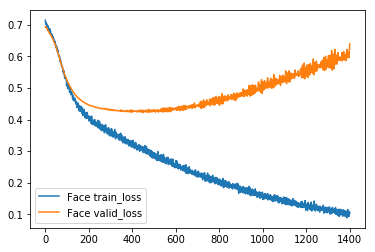

In [14]:
import matplotlib.pyplot as mplot

mplot.plot(train_loss, label='Face train_loss')
mplot.plot(valid_loss, label='Face valid_loss')
mplot.legend()
mplot.show()

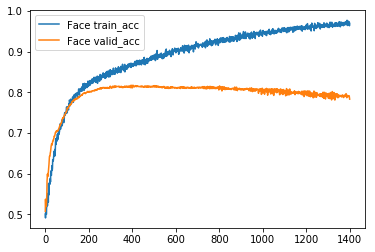

In [15]:
# import matplotlib.pyplot as mplot
mplot.plot(train_acc, label='Face train_acc')
mplot.plot(valid_acc, label='Face valid_acc')
mplot.legend()
mplot.show()

In [19]:
test_acc, test_loss = [], []

with tf.Session() as sess:
    # Restore the validated model
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints/'))
    
    ################## Test
    acc_batch = []
    loss_batch = []    
    # Loop over batches
    for x, y in get_batches(batch_size=100, X=X_test_norm, y=Y_test_onehot):

        # Feed dictionary
        feed = {inputs_ : x, labels_ : y, keep_prob_ : 1.0}

        # Loss
        loss, acc, con = sess.run([cost, accuracy, confusion], feed_dict = feed)
        acc_batch.append(acc)
        loss_batch.append(loss)

    # Store
    test_acc.append(np.mean(acc_batch))
    test_loss.append(np.mean(loss_batch))

    # Print info for every iter/epoch
    print("Test loss: {:6f}".format(np.mean(test_loss)),
          "Test acc: {:.6f}".format(np.mean(test_acc)))

INFO:tensorflow:Restoring parameters from checkpoints/dcnn-face-yalda-Copy6.ckpt
Test loss: 0.327950 Test acc: 0.894643


In [20]:
con.shape

(2, 2)

In [22]:
# sensitivity: 1st col or true prediction condition
con[0, 0]/ (con[0, 0] + con[1, 0])

1.0

In [23]:
# specificity: 2nd col or false prediction condition
# (1st row, 2nd col)/ 
con[0, 1]/ (con[0, 1] + con[1, 1])

0.31578947368421051

In [24]:
# accuracy: true prediction condition
con[0, 0]/ (con[0, 0] + con[1, 1])

0.86170212765957444